# Updates

In [1]:
!pip install -U transformers -q
!pip install -U accelerate -q
!pip install torcharrow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.8.0 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.21.4 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.2

After updating packages, restart the session and then start your notebook from imports.

# Imports

In [23]:
import torch
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torcharrow as ta
from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model

In [3]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def load_model(model_args):
    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [5]:
model, tokenizer = load_model(MODEL_ARGS)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.38k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Reading the Data

In [26]:
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

def process_data(data):
    reviews = []
    labels = []
    embeddings = []

    for item in data:
        reviews.append(item["text"])
        labels.append(item["label"])
        embeddings.append(item['embedding'])

    return reviews, labels, embeddings

def create_dataframe(reviews, labels, embeddings):
    df = pd.DataFrame({
        'review': reviews,
        'label': labels,
        'embedding': embeddings
    })
    return df

In [27]:
train_df = create_dataframe(
    *process_data(
        read_jsonl("imdb/train_imdb.jsonl")
    )
)

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


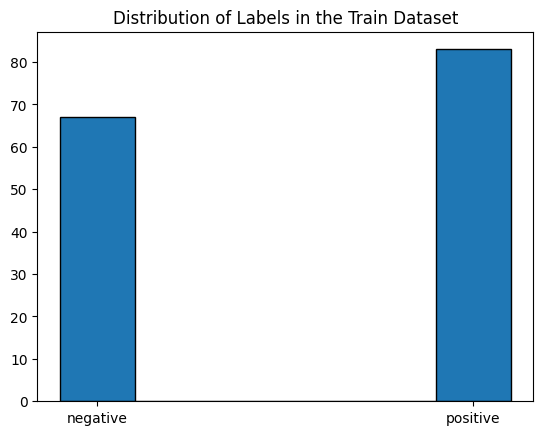

In [29]:
plt.hist(train_df['label'], bins=[-0.1, 0.1, 0.9, 1.1], edgecolor="black")
plt.title("Distribution of Labels in the Train Dataset")
plt.xticks([0, 1], labels=['negative', 'positive'])
plt.show()

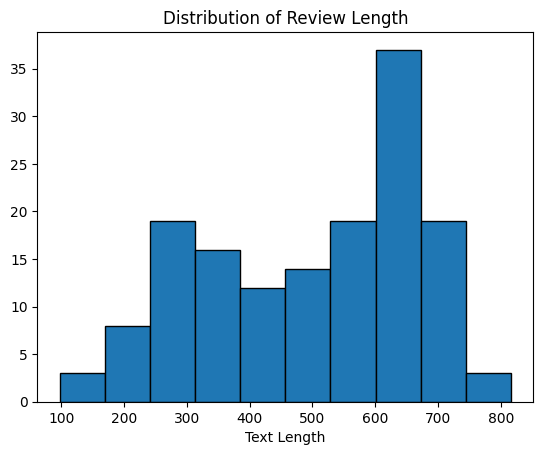

In [31]:
review_list = train_df['review']
text_len_dist = [ len(review) if review else 0 for review in review_list ]
plt.hist(text_len_dist, edgecolor="black")
plt.title("Distribution of Review Length")
plt.xlabel("Text Length")
plt.show()

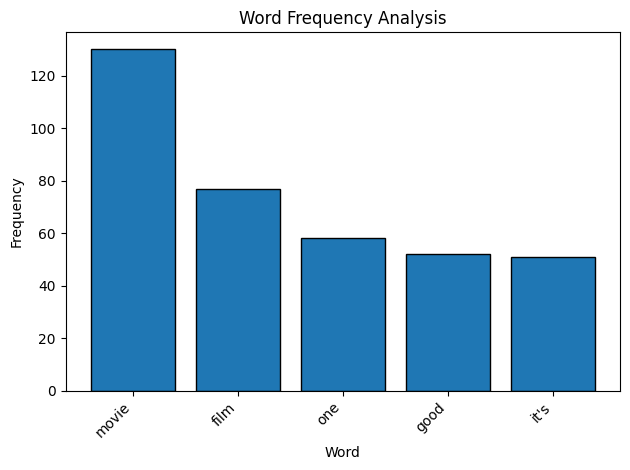

In [32]:
with open("stopwords.txt", 'r') as file:
        stopwords = [line.strip() for line in file]

tokens = [token.lower() for review in review_list \
          for token in review.replace("<br />", "").split() \
                if token.lower() not in stopwords  ]

token_counts = Counter(tokens)
top_tokens = dict(sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:5])

plt.bar(top_tokens.keys(), top_tokens.values(), edgecolor="black")
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Word Frequency Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Classification with K Nearest Neighbors

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Step 1: Data Preparation
# Convert to PyTorch tensors
X_tensor = torch.tensor(train_df['embedding'], dtype=torch.float32)
y_tensor = torch.tensor(train_df['label'], dtype=torch.long)

# Split data into train and test sets
X_train, X_validation, y_train, y_validation = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_validation = torch.tensor(scaler.transform(X_validation), dtype=torch.float32)

# Step 2: Define the Neural Network for Feature Extraction
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 10
output_size = 2

model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the Neural Network
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 4: Extract Features Using the Trained Neural Network
model.eval()
with torch.no_grad():
    train_features = model.fc1(X_train).numpy()
    validation_features = model.fc1(X_validation).numpy()

# Step 5: Train and Evaluate KNN Classifier
# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)

# Train KNN on the extracted features
knn.fit(train_features, y_train.numpy())

# Make predictions with KNN
y_pred = knn.predict(validation_features)

# Evaluate the model
accuracy = accuracy_score(y_validation.numpy(), y_pred)
print(f'Accuracy with NN features: {accuracy * 100:.2f}%')

Epoch [1/15], Loss: 0.7714
Epoch [2/15], Loss: 0.7120
Epoch [3/15], Loss: 0.6624
Epoch [4/15], Loss: 0.6217
Epoch [5/15], Loss: 0.5867
Epoch [6/15], Loss: 0.5559
Epoch [7/15], Loss: 0.5285
Epoch [8/15], Loss: 0.5032
Epoch [9/15], Loss: 0.4801
Epoch [10/15], Loss: 0.4584
Epoch [11/15], Loss: 0.4379
Epoch [12/15], Loss: 0.4186
Epoch [13/15], Loss: 0.4003
Epoch [14/15], Loss: 0.3831
Epoch [15/15], Loss: 0.3666
Accuracy with NN features: 100.00%
